## Preprocessing

In [1]:
from scipy.io import arff
import pandas as pd
import numpy as np

data = arff.loadarff('4year.arff')
df = pd.DataFrame(data[0])
df['bankruptcy'] = (df['class']==b'1')
del df['class']
df.columns = ['X{0:02d}'.format(k) for k in range(1,65)] + ['bankruptcy']

In [2]:
from sklearn.preprocessing import Imputer

imr = Imputer(missing_values='NaN', strategy='mean', axis=0)
imr = imr.fit(df.values)
imputed_data = imr.transform(df.values)

In [3]:
from sklearn.model_selection import train_test_split

X, y = imputed_data[:, :-1], imputed_data[:, -1]

X_train, X_test, y_train, y_test =\
    train_test_split(X, y, 
                     test_size=0.3, 
                     random_state=0, 
                     stratify=y)

In [4]:
from sklearn.preprocessing import StandardScaler

stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)


# Find the 2 most important features
### using Logistic Regression with L1 penalty

In [5]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l1', C=0.01)
lr.fit(X_train_std, y_train)
# print('Training accuracy:', lr.score(X_train_std, y_train))
# print('Test accuracy:', lr.score(X_test_std, y_test))
print("The number of feautures whose coefficients are not 0: %d "%lr.coef_[lr.coef_!=0].shape[0])

The number of feautures whose coefficients are not 0: 2 


In [6]:
X_train_std = X_train_std[:, lr.coef_[0]!=0]
X_test_std = X_test_std[:, lr.coef_[0]!=0]

In [8]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt


def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
#                     alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl
#                     edgecolor='black'
                   )

    # highlight test samples
    if test_idx:
        # plot all samples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100, 
                    label='test set')

## Apply LR

Training accuracy: 94.69%
Test accuracy: 94.69%


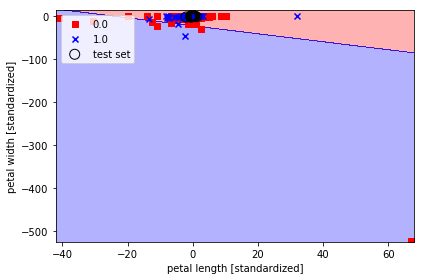

In [24]:
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))


from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=1,random_state=1)
lr.fit(X_train_std, y_train)
print('Training accuracy: %.2f%%'%(lr.score(X_train_std, y_train)*100))
print('Test accuracy: %.2f%%'%(lr.score(X_test_std, y_test)*100))

plot_decision_regions(X=X_combined_std, y=y_combined, classifier=lr,resolution=0.2, test_idx=range(0, 50))

plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


## Apply SVM (RBF kernel is more appropriate)

Training accuracy: 94.82%
Test accuracy: 94.72%


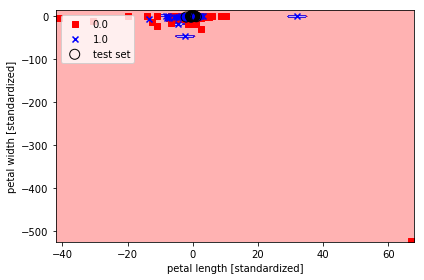

In [25]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf', C=10.0, random_state=1,gamma=0.1)
svm.fit(X_train_std, y_train)
print('Training accuracy: %.2f%%'%(svm.score(X_train_std, y_train)*100))
print('Test accuracy: %.2f%%'%(svm.score(X_test_std, y_test)*100))

plot_decision_regions(X_combined_std, 
                      y_combined,
                      classifier=svm, 
                      test_idx=range(0, 50),
                      resolution=0.2)
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# Apply decision tree

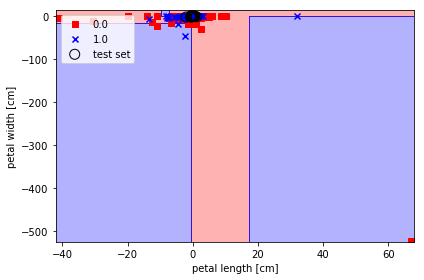

In [16]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='gini', 
                              max_depth=4, 
                              random_state=1)
tree.fit(X_train_std, y_train)


plot_decision_regions(X_combined_std, y_combined, resolution=0.2,
                      classifier=tree, test_idx=range(0, 50))

plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()